In [ ]:
!pip install diffusers
!pip install invisible_watermark transformers accelerate safetensors

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.24.0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
#pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

In [ ]:
import requests
import json
import re

In [ ]:
import requests
import json
import re
def get_text_results(in_text):
  request = requests.post(
      'https://api.theb.ai/v1/chat/completions',
      headers={
          'Authorization': 'Bearer $YOUR_API_KEY',
          'Content-Type': 'application/json'
      },
      data=json.dumps({
          'model': 'gpt-4',
          'messages': [
              {
                  'role': 'user',
                  'content': in_text
              }
          ],
          'stream': False
      })
  )
  response = json.loads(request.content)
  return response['choices'][0]['message']['content']


In [ ]:
def setup_text(in_text):
  return f"""您好，请扮演一个表情包设计师，我会给你提供一段描述s=<{in_text}>，这段描述表明了一个人对于一个场景下表情包的需求，请你根据这段描述设计一个表情包，需包含两个部分，分别是对于图像的描述$d$，这段描述$d$需要使用英文，以及表情包种中包含的文字$t$，按照以下的JSON格式返回"""+"""\{`图像描述':$d$,`文字描述':$t$,`文字在图像中的位置':$[a_1,a_2,b_1,b_2]$\}，$a_1,a_2,b_1,b_2$是左下脚x坐标，左下角y坐标，右上角x坐标以及右上角的y坐标，我希望，整张图像在$[0,1]^2$之间显示，从而$a_1,a_2,b_1,b_2$也在[0,1]之间,同时b1-a1>0.75。文字描述不要太多，表达心情或者意图即可，不需要完整的句子，短语，短句或者语气词就行，最多三个单词或文字。图像描述需要突出主体内容，风格，以及心情。"""

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
def fuse(img, txt_des, position):
    """
    将文字融合到图像中指定位置。

    :param img: PIL.Image对象，你要融合文字的图像。
    :param txt_des: 要融合的文字描述。
    :param position: 文字在图像中的位置，格式为[a1, a2, b1, b2]。
    :return: 融合了文字的图像对象。
    """
    draw0 = ImageDraw.Draw(img)

    font = ImageFont.truetype("/content/SimHei.ttf", size=100)
    dummy_img = Image.new('RGBA', (10, 10))
    draw = ImageDraw.Draw(dummy_img)
    text_width, text_height = draw.textsize(txt_des, font=font)

    a1,a2,b1,b2 = position
    width_wished,height_wished=np.abs(b1-a1),np.abs(b2-a2)
    mean_x,mean_y,bias_x,bias_y = (a1+b1)/2,(a2+b2)/2,width_wished/2,height_wished/2
    ratio_wished = height_wished/width_wished
    ratio = text_height/text_width

    width, height = img.size

    if ratio>ratio_wished:
      width_wished=height_wished/ratio
      bias_x=bias_y/ratio
      target_fontsize=height*height_wished/text_height*100
    else:
      height_wished=width_wished*ratio
      bias_y=bias_x*ratio
      target_fontsize=width*width_wished/text_width*100

    refined_lefttop_x,refined_lefttop_y=mean_x-bias_x,mean_y+bias_y

    font2 = ImageFont.truetype("/content/SimHei.ttf", size=int(target_fontsize))

    text_width, text_height = draw.textsize(txt_des, font=font2)
    text_x = max(int(refined_lefttop_x*width),0)
    text_y = max(int((refined_lefttop_y)*height),0)
    print(text_x,text_y,target_fontsize)
    text_data=np.mean(np.mean(np.array(img)[text_y:text_y+int(height_wished*height),text_x:text_x+int(width_wished*width)],axis=0),axis=0)
    # 在计算出的位置绘制文字
    draw0.text((text_x, text_y), txt_des, font=font2, fill=(255-int(text_data[0]),255-int(text_data[1]),255-int(text_data[2])))

    return img

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

def dynamic_font_color(background_rgb):
    """
    根据背景颜色动态确定字体颜色。
    :param background_rgb: 背景的RGB颜色。
    :return: 选择的字体颜色。
    """

    inverted_color = (255 - background_rgb[0], 255 - background_rgb[1], 255 - background_rgb[2])

    luminance_inverted = (0.299*inverted_color[0] + 0.587*inverted_color[1] + 0.114*inverted_color[2])/255
    luminance_background = (0.299*background_rgb[0] + 0.587*background_rgb[1] + 0.114*background_rgb[2])/255

    contrast_ratio = luminance_inverted / luminance_background if luminance_background > 0 else 0

    if contrast_ratio < 1.5:
        scale_factor = (1.5 / (0.01+contrast_ratio))
        adjusted_color = tuple(max(min(int(c * scale_factor), 255), 0) for c in inverted_color)
    else:
        adjusted_color = inverted_color

    return (adjusted_color[1],adjusted_color[2],adjusted_color[0])

def fuse(img, txt_des, position, outline=True):
    """
    将文字融合到图像中指定位置，并且根据背景颜色动态调整字体颜色，可选择性添加文字轮廓。
    :param img: PIL.Image对象，你要融合文字的图像。
    :param txt_des: 要融合的文字描述。
    :param position: 文字在图像中的位置，格式为[a1, a2, b1, b2]。
    :param outline: 是否在文字周围绘制轮廓。
    :return: 融合了文字的图像对象。
    """
    draw1 = ImageDraw.Draw(img)
    font = ImageFont.truetype("/content/SimHei.ttf", size=100)
    dummy_img = Image.new('RGBA', (10, 10))
    draw = ImageDraw.Draw(dummy_img)
    text_width, text_height = draw.textsize(txt_des, font=font)
    # 计算文字位置
    # position中的坐标为比例坐标，需要转化为实际坐标

    a1,a2,b1,b2 = position
    width_wished,height_wished=np.abs(b1-a1),np.abs(b2-a2)
    mean_x,mean_y,bias_x,bias_y = (a1+b1)/2,(a2+b2)/2,width_wished/2,height_wished/2
    ratio_wished = height_wished/width_wished
    ratio = text_height/text_width

    width, height = img.size

    if ratio>ratio_wished:
      width_wished=height_wished/ratio
      bias_x=bias_y/ratio
      target_fontsize=height*height_wished/text_height*100
    else:
      height_wished=width_wished*ratio
      bias_y=bias_x*ratio
      target_fontsize=width*width_wished/text_width*100

    refined_lefttop_x,refined_lefttop_y=mean_x-bias_x,mean_y+bias_y
    print(refined_lefttop_x,refined_lefttop_y)
    font2 = ImageFont.truetype("/content/SimHei.ttf", size=int(target_fontsize))


    # 文字绘制在左下角到右上角定义的框里面
    # 这个矩形框可以被用来对齐和调整文本大小
    text_width, text_height = draw.textsize(txt_des, font=font2)
    text_x = max(int(refined_lefttop_x*width),0)
    text_y = max(int((refined_lefttop_y)*height),0)
    # 采样背景颜色
    background_sample = np.array(img)[text_y:text_y+text_height, text_x:text_x+text_width]
    background_color = np.mean(np.mean(background_sample, axis=0), axis=0).astype(int)
    font_color = dynamic_font_color(tuple(background_color))

    # 绘制文字
    if outline:
        # 绘制文字轮廓
        outline_width = 10
        for angle in range(0, 360, 15):
            offset = np.array([
                np.cos(np.radians(angle)) * outline_width,
                np.sin(np.radians(angle)) * outline_width
            ]).astype(int)
            draw1.text((text_x+offset[0], text_y+offset[1]), txt_des, font=font2, fill=(0, 0, 0))

    draw1.text((text_x, text_y), txt_des, font=font2, fill=font_color)

    return img

In [ ]:

def get_meme(in_text):
  for i in range(10):
    try:
      prompt = get_text_results(setup_text(in_text)).replace('\n','')
      #print(prompt)
      match = re.search(r'{(.*?)}', prompt)

      json_string = "{"+match.group(1)+"}"
      #print(json_string)
      json_object = json.loads(json_string)
      pic_des = json_object['图像描述']
      txt_des = json_object['文字描述']
      position = json_object['文字在图像中的位置']
      break
    except:
      continue
  with torch.no_grad():

    img = pipe(prompt=pic_des).images[0]
    img_done = fuse(img,txt_des,position)
  return json_object,pic_des,txt_des,position,img,img_done


  0%|          | 0/50 [00:00<?, ?it/s]

0.2715116279069767 0.2


<ipython-input-20-867be0f9c41a>:39: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt_des, font=font)
<ipython-input-20-867be0f9c41a>:67: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(txt_des, font=font2)


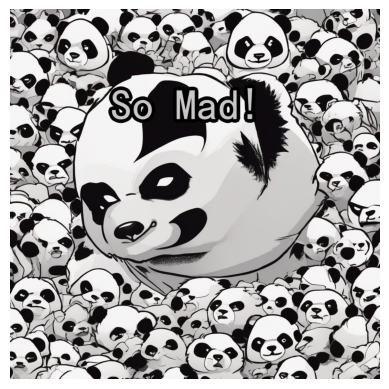

In [ ]:
json_obj,pic_des,txt_des,position,img,img_done = get_meme('一张熊猫的表情包，表达生气的心情，可爱风格')
plt.axis('off')
plt.imshow(img_done)